# GA & PSO Comparison

In [4]:
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

## Load GA & PSO Results

In [ ]:
# Paths to results
GA_RESULTS_PATH = "experiments/results/ga/"
PSO_RESULTS_PATH = "experiments/results/pso/"

# Load results
ga_results = pd.read_csv(GA_RESULTS_PATH)
pso_results = pd.read_csv(PSO_RESULTS_PATH)

# Add algorithm labels
ga_results["algorithm"] = "GA"
pso_results["algorithm"] = "PSO"

# Combine results
combined_results = pd.concat([ga_results, pso_results], ignore_index=True)

PermissionError: [Errno 13] Permission denied: '../experiments/results/ga/'

## Plot Boxplots for Fitness & Evaluations

In [14]:
# Plot fitness boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(x="num_companies", y="sharpe_ratio", hue="algorithm", data=combined_results, palette={"GA": "blue", "PSO": "orange"})
plt.title("Fitness Comparison by Portfolio Size")
plt.xlabel("Number of Assets")
plt.ylabel("Sharpe Ratio")
plt.legend(title="Algorithm")
plt.show()

# Plot evaluations boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(x="num_companies", y="n_evaluations", hue="algorithm", data=combined_results, palette={"GA": "blue", "PSO": "orange"})
plt.title("Evaluations Comparison by Portfolio Size")
plt.xlabel("Number of Assets")
plt.ylabel("Number of Evaluations")
plt.legend(title="Algorithm")
plt.show()

NameError: name 'combined_results' is not defined

<Figure size 1200x800 with 0 Axes>

## Wilcoxon Signed-Rank Test for Pairwise Comparison

In [ ]:
alpha = 0.05

# Iterate over unique portfolio sizes
for num_companies in combined_results["num_companies"].unique():
    print(f"\nPortfolio Size: {num_companies}")

    # Filter results for the current portfolio size
    ga_data = combined_results[(combined_results["num_companies"] == num_companies) & (combined_results["algorithm"] == "GA")]
    pso_data = combined_results[(combined_results["num_companies"] == num_companies) & (combined_results["algorithm"] == "PSO")]

    # Perform Wilcoxon test for fitness
    stat, p_value = wilcoxon(ga_data["sharpe_ratio"], pso_data["sharpe_ratio"])
    print(f"Fitness - GA Mean: {ga_data['sharpe_ratio'].mean():.4f}, PSO Mean: {pso_data['sharpe_ratio'].mean():.4f}")
    print("The difference in fitness is statistically significant." if p_value < alpha else "The difference in fitness is NOT statistically significant.")

    # Perform Wilcoxon test for evaluations
    stat, p_value = wilcoxon(ga_data["n_evaluations"], pso_data["n_evaluations"])
    print(f"Evaluations - GA Mean: {ga_data['n_evaluations'].mean():.4f}, PSO Mean: {pso_data['n_evaluations'].mean():.4f}")
    print("The difference in evaluations is statistically significant." if p_value < alpha else "The difference in evaluations is NOT statistically significant.")


## Friedman Test for Overall Algorithm Comparison

In [ ]:
from scipy.stats import friedmanchisquare

# Prepare data for Friedman test
fitness_data = [
    combined_results[(combined_results["num_companies"] == num_companies) & (combined_results["algorithm"] == "GA")]["sharpe_ratio"].values
    for num_companies in combined_results["num_companies"].unique()
] + [
    combined_results[(combined_results["num_companies"] == num_companies) & (combined_results["algorithm"] == "PSO")]["sharpe_ratio"].values
    for num_companies in combined_results["num_companies"].unique()
]

# Perform Friedman test for fitness
stat, p_value = friedmanchisquare(*fitness_data)
print("Friedman Test for Fitness")
print(f"Statistic: {stat:.4f}, P-Value: {p_value:.4f}")
print("The difference in fitness across algorithms is statistically significant." if p_value < alpha else "The difference in fitness across algorithms is NOT statistically significant.")

## Fine-Tuning


Sharpe Ratio (best) - Statistical Tests
GA Mean: 0.7640, PSO Mean: 0.7783
Wilcoxon Test: Statistic=102.0000, P-Value=0.0034
Difference is statistically significant.
Paired t-Test: Statistic=-2.9553, P-Value=0.0060
Difference is statistically significant.

Annual Return (best) - Statistical Tests
GA Mean: 8.8367, PSO Mean: 11.6133
Wilcoxon Test: Statistic=175.0000, P-Value=0.1574
Difference is NOT statistically significant.
Paired t-Test: Statistic=-1.4351, P-Value=0.1616
Difference is NOT statistically significant.

Execution Time (best) - Statistical Tests
GA Mean: 19.9075, PSO Mean: 12.3813
Wilcoxon Test: Statistic=57.0000, P-Value=0.0001
Difference is statistically significant.
Paired t-Test: Statistic=5.2511, P-Value=0.0000
Difference is statistically significant.

Sharpe Ratio (median) - Statistical Tests
GA Mean: 0.6678, PSO Mean: 0.7491
Wilcoxon Test: Statistic=3.0000, P-Value=0.0000
Difference is statistically significant.
Paired t-Test: Statistic=-12.7760, P-Value=0.0000
Diff

c:\Users\lara\BAO_Portfolio-Optimization-Problem\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1127: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


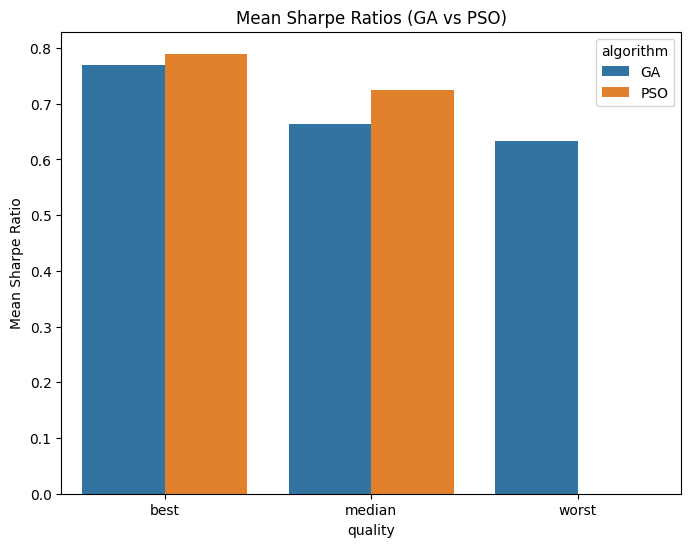

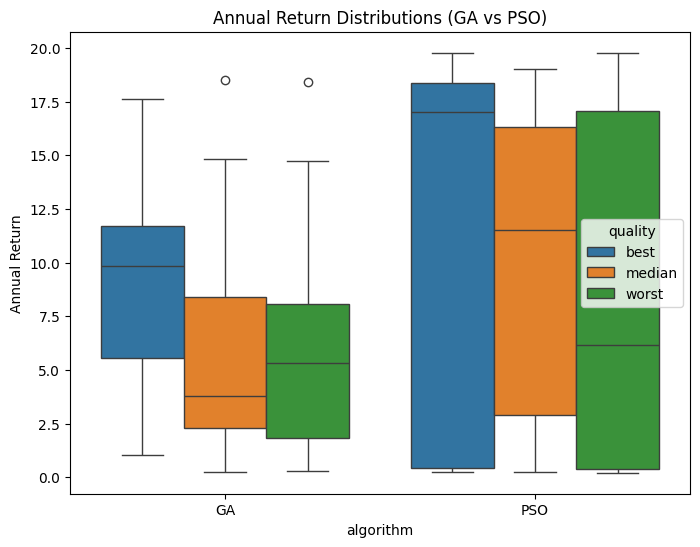

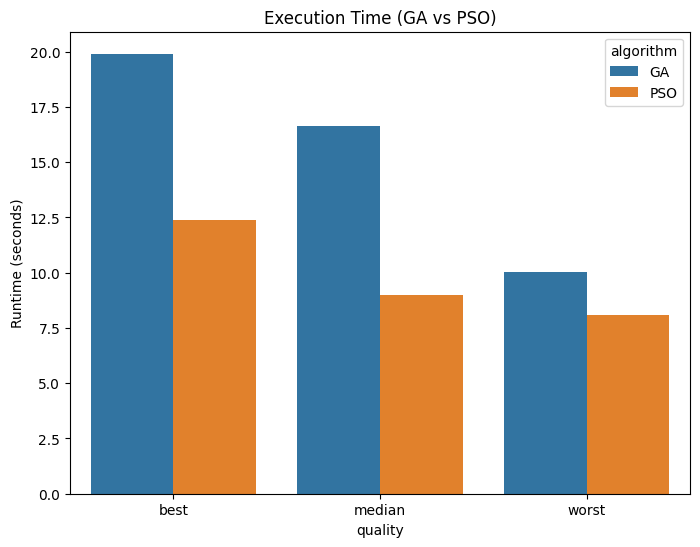

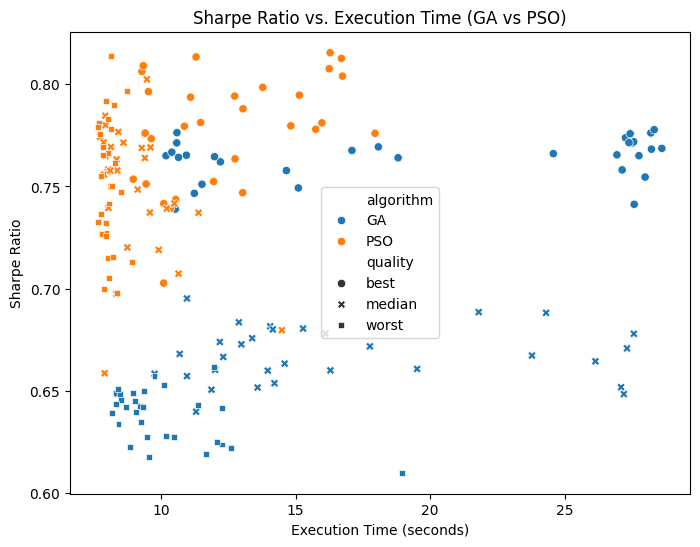

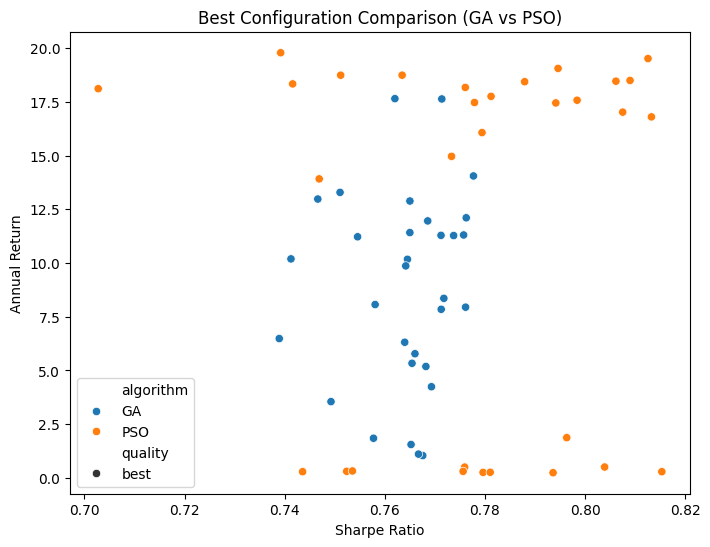

✅ All statistical tests and visualizations completed.


In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, ttest_rel

# Load the final aggregated results
file_path = "c:/Users/lara/BAO_Portfolio-Optimization-Problem/experiments/results/final_fine_tuning_results.csv"
data = pd.read_csv(file_path)

# Set the alpha value for statistical tests
alpha = 0.05

# Statistical Tests
def perform_statistical_tests(ga_data, pso_data, metric, description):
    print(f"\n{description} - Statistical Tests")
    # Drop NaN values to avoid calculation issues
    ga_data = ga_data[metric].dropna()
    pso_data = pso_data[metric].dropna()

    if ga_data.empty or pso_data.empty:
        print("⚠️ One of the data sets is empty after removing NaN values. Skipping test.")
        return

    print(f"GA Mean: {ga_data.mean():.4f}, PSO Mean: {pso_data.mean():.4f}")

    # Wilcoxon test (non-parametric)
    try:
        stat, p_value = wilcoxon(ga_data, pso_data)
        print(f"Wilcoxon Test: Statistic={stat:.4f}, P-Value={p_value:.4f}")
        if p_value < alpha:
            print("Difference is statistically significant.")
        else:
            print("Difference is NOT statistically significant.")
    except ValueError as e:
        print(f"Error in Wilcoxon Test: {e}")

    # Paired t-Test (parametric)
    try:
        stat, p_value = ttest_rel(ga_data, pso_data)
        print(f"Paired t-Test: Statistic={stat:.4f}, P-Value={p_value:.4f}")
        if p_value < alpha:
            print("Difference is statistically significant.")
        else:
            print("Difference is NOT statistically significant.")
    except ValueError as e:
        print(f"Error in Paired t-Test: {e}")

# Perform tests for Best, Median, and Worst Configurations
for quality in ["best", "median", "worst"]:
    ga_data = data[(data["algorithm"] == "GA") & (data["quality"] == quality)]
    pso_data = data[(data["algorithm"] == "PSO") & (data["quality"] == quality)]
    perform_statistical_tests(ga_data, pso_data, "sharpe_ratio", f"Sharpe Ratio ({quality})")
    perform_statistical_tests(ga_data, pso_data, "annual_return", f"Annual Return ({quality})")
    perform_statistical_tests(ga_data, pso_data, "runtime", f"Execution Time ({quality})")

# Visualization Functions
def bar_plot(data, metric, title, ylabel):
    plt.figure(figsize=(8, 6))
    sns.barplot(data=data, x="quality", y=metric, hue="algorithm", errorbar=None)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

def box_plot(data, metric, title, ylabel):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, x="algorithm", y=metric, hue="quality")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

def scatter_plot(data, x_metric, y_metric, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x=x_metric, y=y_metric, hue="algorithm", style="quality")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Visualization: Sharpe Ratio Comparison (Best, Median, Worst)
bar_plot(data, "mean_sharpe", "Mean Sharpe Ratios (GA vs PSO)", "Mean Sharpe Ratio")

# Visualization: Return Distribution (Best, Median, Worst)
box_plot(data, "annual_return", "Annual Return Distributions (GA vs PSO)", "Annual Return")

# Visualization: Execution Time Comparison (Best, Median, Worst)
bar_plot(data, "runtime", "Execution Time (GA vs PSO)", "Runtime (seconds)")

# Visualization: Tradeoff Analysis (Sharpe Ratio vs. Time)
scatter_plot(data, "runtime", "sharpe_ratio", "Sharpe Ratio vs. Execution Time (GA vs PSO)", "Execution Time (seconds)", "Sharpe Ratio")

# Best Configuration Comparison (Sharpe Ratio vs Annual Return)
best_data = data[data["quality"] == "best"]
scatter_plot(best_data, "sharpe_ratio", "annual_return", "Best Configuration Comparison (GA vs PSO)", "Sharpe Ratio", "Annual Return")

print("✅ All statistical tests and visualizations completed.")